In [1]:
import numpy as np
import tensorflow as tf

from models import *
from utils import *
from data import * 

EPOCHS = 10
B = 16
W, H = 224, 224
M = 10
dA, dG = 48, 16
compr_size = 100

In [2]:
dataloader = Dataloader(path='../data/UCF-101/', frames_path='../data/UCF-101-train-1/')
dataloader.load_video_names()
dataloader.make_dirs()
dataloader.create_frames()

100%|██████████| 13320/13320 [15:04<00:00, 14.72it/s]


In [9]:
dataloader = Dataloader(path='../data/UCF-101/', frames_path='../data/UCF-101-train-1/')
x_train, x_val = dataloader.create_data(0, 10)
# L = x_train.shape[0]
# x_train = np.reshape(x_train[:L-L%M], (-1, M, W, H, 3))
# L = x_val.shape[0]
# x_val = np.reshape(x_val[:L-L%M], (-1, M, W, H, 3))

100%|██████████| 830/830 [00:01<00:00, 691.79it/s]


In [10]:
k = 10 # Compresiion parameter : k/48
model = tf.keras.Sequential()
x0 = tf.keras.layers.Input(shape=(W, H, 3))
# Encoder
x1 = tf.keras.layers.Conv2D(16, (5,5), padding='same', strides=2, activation='relu')(x0)
x2 = tf.keras.layers.Conv2D(32, (5,5), padding='same', strides=2, activation='relu')(x1)
# x2_ = tf.keras.layers.Permute((3,2,1,4))(x2)
# x3_ = AttentionBlock(dA, dG)(x2_)
# x3 = tf.keras.layers.Permute((3,2,1,4))(x3_)
x4 = tf.keras.layers.Conv2D(32, (5,5), padding='same', strides=1, activation='relu')(x2)
x5 = tf.keras.layers.Conv2D(32, (5,5), padding='same', strides=1, activation='relu')(x4)
x6 = tf.keras.layers.Conv2D(k, (5,5), padding='same', strides=1, activation='relu')(x5)
x7 = tf.keras.layers.Flatten()(x6)
print(x7.shape)
# Decoder
x0t = tf.keras.layers.Reshape((M, W//4, H//4, -1))(x7)
# x0t_ = tf.keras.layers.Permute((3,2,1,4))(x0t)
# x1t_ = AttentionBlock(dA, dG)(x0t_)
# x1t = tf.keras.layers.Permute((3,2,1,4))(x1t_)
x2t = tf.keras.layers.Reshape((W//4, H//4, -1))(x0t)
x3t = tf.keras.layers.Conv2DTranspose(32, (5,5), padding='same', strides=1, activation='relu')(x2t)
x4t = tf.keras.layers.Conv2DTranspose(32, (5,5), padding='same', strides=1, activation='relu')(x3t)
x5t = tf.keras.layers.Conv2DTranspose(32, (5,5), padding='same', strides=1, activation='relu')(x4t)
x6t = tf.keras.layers.Conv2DTranspose(16, (5,5), padding='same', strides=2, activation='relu')(x5t)
x7t = tf.keras.layers.Conv2DTranspose(3, (5,5), padding='same', strides=2, activation='sigmoid')(x6t)
# x8t = tf.keras.layers.Reshape((M, W, H, 3))(x7t)
# Model
model = tf.keras.Model(x0, x7t)
opt = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=opt, loss=loss_function)

(None, 31360)


In [12]:
# model.load_weights('../checkpoint/aeimage-1_10')
model.fit(x_train, x_train, validation_data=(x_val, x_val), shuffle=False, epochs=1, batch_size=32)
# model.save_weights('../checkpoint/aeimage-1_10')

235/235 [==============================] - 555s 2s/step - loss: 0.0025 - val_loss: 0.0024


tf.Tensor(0.0023958625, shape=(), dtype=float32)


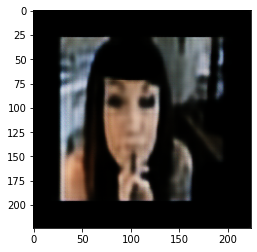

In [15]:
import matplotlib.pyplot as plt

y = model.predict(x_train[0:B])
img = x_train[0]
img_ = y[0]
# img_ = x_train[0, 8] + np.random.rand(W, H, 3)
print(loss_function(img, img_))
# imgplot = plt.imshow(img)
imgplot = plt.imshow(img_)
plt.show()